__Can We Predict the Severity of Forest Fires?__ by Chris Look, Eric Shao

The range of applications for data science is immense, ranging from the largest scale macroeconomic estimations to the process by which drugs interact with proteins. In this tutorial, we intend to use data science to predict the impact a forest fire has based on meteorological and temporal conditions. 


A brief description of the dataset: A set of instances in portugal where forest fires broke out. There are 517 instances, each with 12 attributes that are described below as taken from the UCI description:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
  sense to model with the logarithm transform). 
  

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [0]:
#getting data 
forest_fires = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv")
#normalizing fire area values, most are small, with a couple of large ones
#Follows power law distribution as shown later
forest_fires['log_area'] = np.log(forest_fires['area']+1)
forest_fires_copy = forest_fires.copy()
forest_fires.head(5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0.0


Intuitively, we would expect fires to be both more dangerous and more frequent during the summer months. The following code produces a histogram that shows the reported number of fires for each month. The data for this histogram was pulled from the main forest_fires dataframe by iterating through each entry in forest_fires.



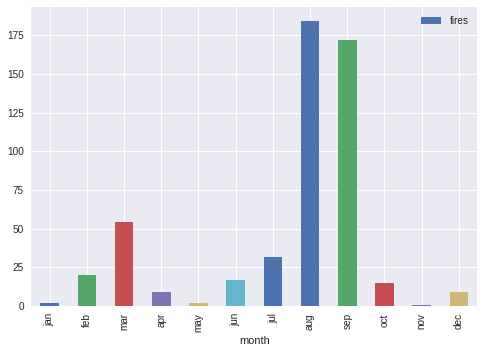

In [0]:
new = []
for month in ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']:
  count = 0
  for index, row in forest_fires.iterrows():
    if forest_fires.at[index, 'month'] == month:
      count+=1
      
  new.append((month, count))
df = pd.DataFrame(data = new, columns = ['month', 'fires'])
df.plot.bar(x = 'month', y = 'fires')

To turn month into a more meaningful feature, we used one hot encoding. One hot encoding is a method by which a categorical variable is converted into a more machine learning friendly form. These are typically applied to distinct categories like cat and dog, but can also be done for others. In this case, months do have some sort of relationship, though not linear. It is cyclical. This makes encoding it into a numeric variable more difficult and is the subject of the below attempt. In an attempt to avoid creating fake relationships between months, we make them distinct variables. One hot encoding removes the relationship between each categorical variable. 
To achieve one hot encoding, we created a feature for each month, and each instance had a 1 if it was from that month, and 0 otherwise. 


In [0]:
#One Hot Encoding of Months
forest_fires['jan'] = np.where(forest_fires['month'] == 'jan',1,0)
forest_fires['feb'] = np.where(forest_fires['month'] == 'feb',1,0)
forest_fires['mar'] = np.where(forest_fires['month'] == 'mar',1,0)
forest_fires['apr'] = np.where(forest_fires['month'] == 'apr',1,0)
forest_fires['may'] = np.where(forest_fires['month'] == 'may',1,0)
forest_fires['jun'] = np.where(forest_fires['month'] == 'jun',1,0)
forest_fires['jul'] = np.where(forest_fires['month'] == 'jul',1,0)
forest_fires['aug'] = np.where(forest_fires['month'] == 'aug',1,0)
forest_fires['sep'] = np.where(forest_fires['month'] == 'sep',1,0)
forest_fires['oct'] = np.where(forest_fires['month'] == 'oct',1,0)
forest_fires['nov'] = np.where(forest_fires['month'] == 'nov',1,0)
forest_fires['dec'] = np.where(forest_fires['month'] == 'dec',1,0)
#normalizing fire area values, most are small, with a couple of large ones
#Follows power law distribution as shown later


In [0]:
forest_fires.head(5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,...,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,...,1,0,0,0,0,0,0,0,0,0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,...,0,0,0,0,0,0,0,1,0,0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,...,0,0,0,0,0,0,0,1,0,0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,...,1,0,0,0,0,0,0,0,0,0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,...,1,0,0,0,0,0,0,0,0,0


To make a prediction, we used multiple linear regression. But what is multiple linear regression? It is a relatively simple machine learning method, extending the commonly used linear regression that correlates one variable x with y, to see if any increase in x is found to occur often with an increase or decrease in y linearly. Multiple linear regression, as the name implies, adds in several variables, say x1,x2...xn, and an intercept, to standardize the sum. For example if one were to predict test scores from hours studying, people who spend no time studying likely do not all get 0’s so an intercept is added to normalize for it. The model is trained by giving each of the x’s a weight, so that yest = a1x1 + a2x2 +… + anxn + intercept. Again, with our test scores example, we may want to predict score from hours studying and hours watching T.V. One would imagine the weight for hours watching TV is negative, since the more hours one watches T.V, the lower the predicted score, and the opposite for hours studying. 


Our goal was to predict based on month and weather (temporal and meteorological) conditions, how large a fire could be predicted to be. Thus we included the one hot encoded months, and the  weather conditions of the day, relative humidity (RH), wind, rain, and temperature. The weights for each month are below:


In [0]:
#predicting based on weather and month.
X_months = forest_fires[['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','RH','rain','temp','wind']].values
Y_months = forest_fires['log_area'].values

reg_inter = linear_model.LinearRegression()
reg_inter.fit(X_months, forest_fires['log_area'])
print("all coefficients : " + str(reg_inter.coef_))
print("just month coefficients : " + str(reg_inter.coef_[:11]))
print("intercept: %f" % reg_inter.intercept_)

all coefficients : [-0.67017519  0.25015009 -0.22546045  0.12842931  0.70387954 -0.449044
 -0.25700799 -0.29841845  0.06054825 -0.16297689 -0.88415296  1.80422874
  0.00357983  0.05880873  0.0434159   0.05489355]
just month coefficients : [-0.67017519  0.25015009 -0.22546045  0.12842931  0.70387954 -0.449044
 -0.25700799 -0.29841845  0.06054825 -0.16297689 -0.88415296]
intercept: 0.013850


We found, very surprisingly, that the largest positive weight by far was December, while the largest negative ones were the summer months. This counter-intuitively suggests that there is a negative correlation with temperature and area of destruction by forest fire. 

Ok, so now we have the model. How do we test it? We used all of the data in creating the model, so testing the model with that same data will always produce a perfect prediction, which is ultimately useless for our purposes. We utilize 10-fold cross validation, which involves segmenting the data in 10 different segments. We then create a model based on 9 of the segments, and test its accuracy on the last segment, repeating until each segment has been the segment left out. We can then combine all of the predictions, and find the error, and thus how successful we are in creating a model that can predict area based on the aforementioned factors. 


In [0]:
#Use Linear Regression to predict area based on meteorological features and month
resid = 0
kf = KFold(n_splits=10)
y_pred = []
y_true = []

for train, test in kf.split(X_months):
  clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
  clf.fit(X_months[train], Y_months[train])
  reg = LinearRegression().fit(X_months[train], Y_months[train])
  y_test = reg.predict(X_months[test])
  y_pred = np.concatenate([y_pred,y_test])
  y_true = np.concatenate([y_true,Y_months[test]])
print("coeff array: " + str(reg.coef_))
err = mean_absolute_error(y_pred, y_true)
print(err)


coeff array: [-6.23971661e-01  3.38853755e-01 -1.45465863e-01  2.84916367e-02
 -9.17325038e-01 -6.22369123e-01 -1.34903983e-01 -5.96541053e-02
  2.83753191e-01  1.04370623e-02  1.38777878e-16  1.84215413e+00
  1.99572646e-03 -1.41871884e+00  2.76016124e-02  4.01327550e-02]
1.2642785730793868


Testing out this model on the dataset using 10-fold cross validation, we find that the results are very disappointing. The r value for the output actual to output predicted plot was -0.186, implying that the model was useless. We ignore the p value in this case because the target r value was 1. We found that this model, including meteorological and temporal features was not useful.


r: -0.186476  p: 0.000020


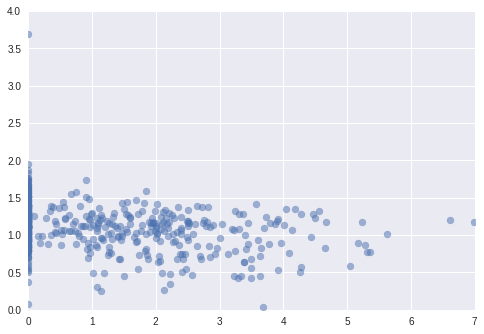

In [0]:
#plot actual vs fitted
plt.scatter(y_true, y_pred, alpha=0.5)
plt.axis([0, 7, 0, 4])
slope, intercept, r_value, p_value, std_err = stats.linregress(y_true, y_pred)
#Dissapointing r value.
print("r: %f  p: %f" % (r_value,p_value))

However, looking at the histogram of the fires over time uncovers a bias. While the fires during the winter had large areas, there are significantly fewer of them, with nearly 0 in jan and nov. This suggests that fires are much more likely to occur during the hotter summer months, but when they occur during winter, on average they tend to be more severe. This is also shown by the violin plot. Because of the high number of 0’s for the area, the graphs seem to be “bottom weighted” and again follow a power law distribution. Hence, we decided to predict the regression of a non-negligible fire, where the burned area was greater than 0 hectare. 


12


([<matplotlib.axis.XTick at 0x7f9b6db0b550>,
 <a list of 12 Text xticklabel objects>)

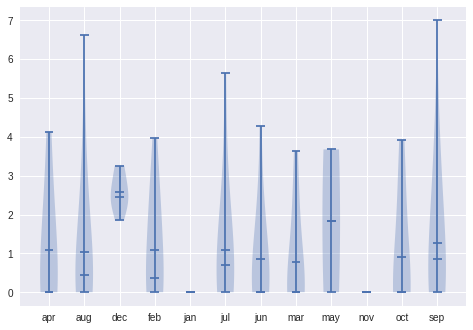

In [0]:
#get distribution of area burned by month.
grouped = forest_fires.groupby('month')
pos = []
spreads = []
for name,group in grouped:
    pos.append(name)
    spreads.append(grouped.get_group(name)['log_area'].tolist())
print(len(spreads))
plot = plt.violinplot(spreads, widths=.5,showmeans=True,  showmedians=True,bw_method=0.9)
plt.xticks(np.arange(1,13), pos)

10


([<matplotlib.axis.XTick at 0x7f9b6daf7048>,
 <a list of 10 Text xticklabel objects>)

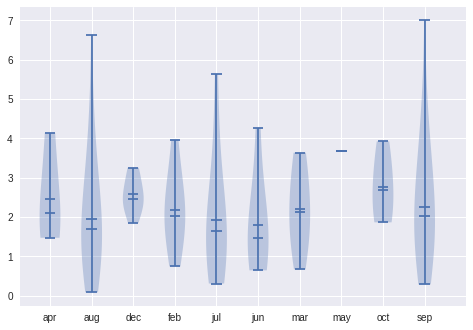

In [0]:
#Take out instances of neglible area
only_fires = forest_fires[forest_fires.area != 0.0]

grouped = only_fires.groupby('month')
pos = []
spreads = []
for name,group in grouped:
    pos.append(name)
    spreads.append(grouped.get_group(name)['log_area'].tolist())
print(len(spreads))
plot = plt.violinplot(spreads, widths=.5,showmeans=True,  showmedians=True,bw_method=0.9)
plt.xticks(np.arange(1,12), pos)

Removing these 0’s to take a look at the non-negligible fires displays a story that seems to make a bit more sense. It appears more that there is little correlation between month and severity of a non-negligible fire, normalizing for amount of data. We attempted a new multiple linear regression model with this non-negligible data. 



Unfortunately we found similar results, with low error, but upon look at the y actual vs y fitted, the plot again has a low r value of -0.2.

error value: 1.053623
coeff array: [ 0.00000000e+00  2.41798101e-02 -1.12066719e-01  2.08178611e-01
  1.28190962e+00 -6.91432877e-01 -6.63825291e-01 -6.12956469e-01
 -1.52539531e-01  3.60537706e-01  1.94289029e-16  3.58015136e-01
 -1.52181018e-03  0.00000000e+00  2.24004673e-02  3.27379202e-02]
r: -0.208232  p: 0.000574


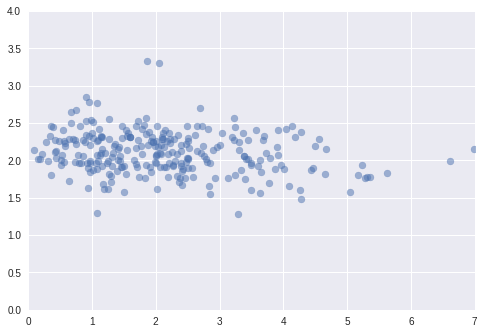

In [0]:
#still disappointing actual vs fitted values
X_fires = only_fires[['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','RH','rain','temp','wind']].values
Y_fires = only_fires['log_area'].values
fires_pred = []
fires_true = []

for train, test in kf.split(X_fires):
  reg = LinearRegression().fit(X_fires[train], Y_fires[train])
  y_test = reg.predict(X_fires[test])
  fires_pred = np.concatenate([fires_pred,y_test])
  fires_true = np.concatenate([fires_true,Y_fires[test]])
err = mean_absolute_error(fires_pred, fires_true)
print("error value: %f" % err)
print("coeff array: " + str(reg.coef_))

plt.scatter(fires_true, fires_pred, alpha=0.5)
plt.axis([0, 7, 0, 4])
slope, intercept, r_value, p_value, std_err = stats.linregress(fires_true, fires_pred)
print("r: %f  p: %f" % (r_value,p_value))


Now we try a different approach to encode time in months.

After restoring the forest_fires dataframe to its original state (i.e. with unaltered area values), we change the “month” value into a different form. We do so by expressing each month by its distance from December. Hopefully this yields a more useful model for predicting fire area.

However, the data itself poses a few challenges. For one, there is a huge range in the recorded burned area of the fires. Almost all of the areas are from about 0-30 ha, but a few data points are in the hundreds, with one nearing 1000. This would result in an extremely unbalanced representation of the data. By instead changing the burned area entry of each fire to log(area+1), we can smooth out the data more without changing any key characteristics.
We then fit a linear regression model to the data, with the dependent variable set to the log(area+1) of the fire, and the independent variable set to the month’s distance from December. 


6.995619625423205
7


([<matplotlib.axis.XTick at 0x7f9b6d8d8e48>,
 <a list of 7 Text xticklabel objects>)

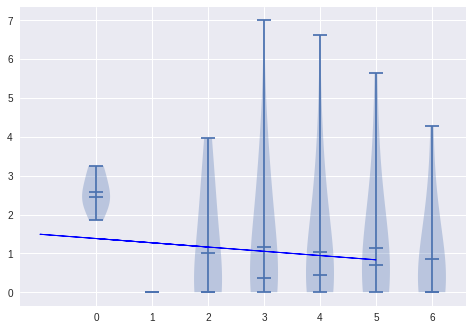

In [0]:
#Using defined months 
#linear regression dropping nothing
forest_fires = forest_fires_copy
forest_fires['distance_from_december'] = 0
for index,row in forest_fires.iterrows():
  if forest_fires.at[index, 'month'] == 'jan' or forest_fires.at[index, 'month'] == 'nov':
    forest_fires.at[index, 'distance_from_december'] = 1
  elif forest_fires.at[index, 'month'] == 'feb' or forest_fires.at[index, 'month'] == 'oct':
    forest_fires.at[index, 'distance_from_december'] = 2
  elif forest_fires.at[index, 'month'] == 'mar' or forest_fires.at[index, 'month'] == 'sep':
    forest_fires.at[index, 'distance_from_december'] = 3
  elif forest_fires.at[index, 'month'] == 'apr' or forest_fires.at[index, 'month'] == 'aug':
    forest_fires.at[index, 'distance_from_december'] = 4
  elif forest_fires.at[index, 'month'] == 'may' or forest_fires.at[index, 'month'] == 'jul':
    forest_fires.at[index, 'distance_from_december'] = 5
  elif forest_fires.at[index, 'month'] == 'jun':
    forest_fires.at[index, 'distance_from_december'] = 6
    
  forest_fires.at[index, 'area'] = np.log(forest_fires.at[index, 'area'] + 1)
print(max(forest_fires['area']))
x = forest_fires['distance_from_december'].values
y = forest_fires['area'].values
x = x.reshape(517,1)
y = y.reshape(517,1)
regr = LinearRegression()
regr.fit(x,y)
regr.coef_
plt.plot(x, regr.predict(x), color='blue', linewidth=1)

grouped = forest_fires.groupby('distance_from_december')
pos = []
spreads = []
for name,group in grouped:
    pos.append(name)
    spreads.append(grouped.get_group(name)['area'].tolist())
print(len(spreads))
plot = plt.violinplot(spreads, widths=.5,showmeans=True,  showmedians=True,bw_method=0.9)
plt.xticks(np.arange(1,8), pos)

Distance from December and area of fires are still negatively correlated. We again drop the 0 values.

Fitting with the one-hot encoding, there is a negative correlation between distance from December and burn area of fires. Next, we introduce relative humidity, temperature, wind,  and rain into the model.


In [0]:
#Redoing One Hot Encoding of Months
forest_fires['jan'] = np.where(forest_fires['month'] == 'jan',1,0)
forest_fires['feb'] = np.where(forest_fires['month'] == 'feb',1,0)
forest_fires['mar'] = np.where(forest_fires['month'] == 'mar',1,0)
forest_fires['apr'] = np.where(forest_fires['month'] == 'apr',1,0)
forest_fires['may'] = np.where(forest_fires['month'] == 'may',1,0)
forest_fires['jun'] = np.where(forest_fires['month'] == 'jun',1,0)
forest_fires['jul'] = np.where(forest_fires['month'] == 'jul',1,0)
forest_fires['aug'] = np.where(forest_fires['month'] == 'aug',1,0)
forest_fires['sep'] = np.where(forest_fires['month'] == 'sep',1,0)
forest_fires['oct'] = np.where(forest_fires['month'] == 'oct',1,0)
forest_fires['nov'] = np.where(forest_fires['month'] == 'nov',1,0)
forest_fires['dec'] = np.where(forest_fires['month'] == 'dec',1,0)
only_fires = forest_fires[forest_fires.area != 0.0]



In [0]:
reg = linear_model.LinearRegression()
terms = only_fires[['distance_from_december', 'RH', 'temp', 'wind', 'rain']]
reg.fit(terms, only_fires['area'])
m = reg.coef_
b = reg.intercept_
print("The coefficients of the linear model are as follows: {}".format(m))

The coefficients of the linear model are as follows: [-0.20516986 -0.00145968  0.01897225  0.03399233  0.01359418]


We Perform Cross validation again, plotting predicted to actual values.
Unfortunately we found similar results, with low error, but upon look at the y actual vs y fitted, the plot again has a low r value of -0.17293632365279513.


-0.17293632365279513


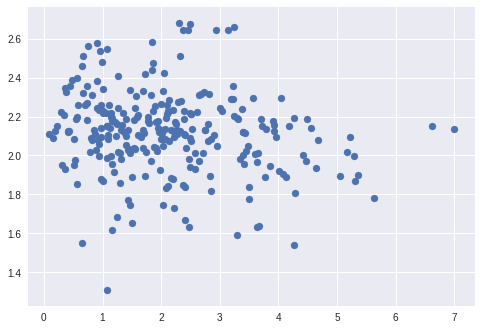

In [0]:
kf = KFold(n_splits = 10)
kf.split(only_fires)
predictions = []
y_true = []
x_temp = only_fires[['distance_from_december', 'RH', 'temp', 'wind', 'rain']].values
y_temp = only_fires['area'].values
for train_index, test_index in kf.split(only_fires):
  x_train, x_test = x_temp[train_index], x_temp[test_index]
  area_train, area_test = y_temp[train_index], y_temp[test_index]
  reg = linear_model.LinearRegression()
  reg.fit(x_train, area_train)
  predictions = np.concatenate([predictions, reg.predict(x_test)])
  y_true = np.concatenate([y_true, area_test])
predictions
error = mean_absolute_error(y_true, predictions)
error
plt.scatter(y_true, predictions)
slope, intercept, r_value, p_value, std_error = stats.linregress(y_true, predictions)
print(r_value)

In [0]:
#regression doesnt seem to work, maybe not enough data or features.

In a last ditch effort, we will try binary classification, with the two classes being negligible vs non-negligible fires.
  
Classification differs from regression because of the difference in goals. In classification, one is given a set of discrete classes to predict, while regression aims to predict from a range of values. Often this can be extended from repression, where if the values vary from 0 to 1, then if it is picked as 1 if the predicted y value is > .5 and otherwise 0. Logistic regression is a good example of this kind of approach. Another method is using decision trees, which at a high level, divide the decision space into hyper cubes. This can be better interpreted as a tree, where at each feature there is a split, and this is done recursively for all features, and a decision is given in the end. Repeating this with several different subsets or “batches” of the data creates a forest of trees, each with its own prediction. Finding the mode of the prediction results in the decision of the forest. This approach is appropriately called random forest.

Here this concept is applied on negligible vs non-negligible fires. This was determined by whether the value in the area column was equal to 0 or not, if 0 then negligible, otherwise non-negligible. Looking at the split of non-negligible vs negligible, it appears that the split is nearly even, with non-negligible 270 fires, and 247 negligible fires. We trained a random forest model, which instead of performing repression, classified as either 1 or 0. Unfortunately  we found that our results were disappointing, with 40% accuracy. This means that randomly guessing, or just guessing a non-negligible fire would have been more effective. From this we find that there is no immediate value found in our encodings of features on repression and classification. Sometimes things just don't work out.




In [0]:
#Turn to binary classification, neglible fire or not
forest_fires_low = forest_fires
forest_fires_low['is_fire'] = np.where(forest_fires_low['area'] != 0.0, 1,0)

print(forest_fires_low['is_fire'].value_counts())
print(len(forest_fires_low))
X_is_fire = forest_fires_low[['RH','rain','temp','wind',]].values
Y_is_fire = forest_fires_low['is_fire'].values

is_fire_true = []
is_fire_pred = []
#RandomForest classifier with again, disappointing results

for train, test in kf.split(X_is_fire):
  clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
  clf.fit(X_is_fire[train], Y_is_fire[train])
  y_test = clf.predict(X_is_fire[test])
  is_fire_pred = np.concatenate([is_fire_pred,y_test])
  is_fire_true = np.concatenate([is_fire_true ,Y_is_fire[test]])
acc = accuracy_score(is_fire_true,is_fire_pred)
print("accuracy: %f" % (acc))

1    270
0    247
Name: is_fire, dtype: int64
517
accuracy: 0.400387
